In [26]:
import ROOT
import numpy as np

Best thresholds: x≥0.625, y≥0.675  -> Z=676.683, S=58285, B=0


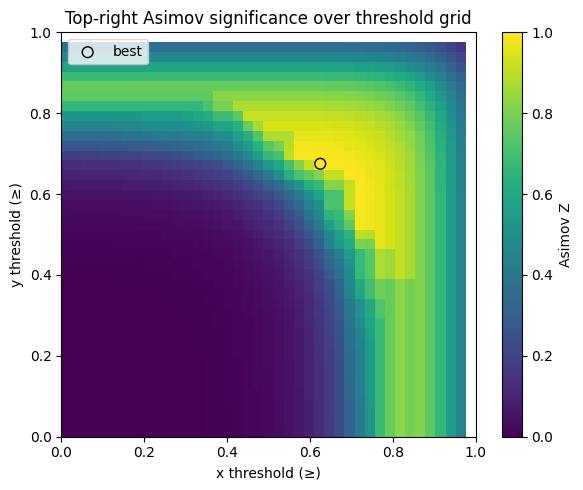

In [30]:
# --- Colab-ready: no extra installs needed ---
import numpy as np
import matplotlib.pyplot as plt

asimov_Z = np.vectorize(
    lambda ss, bb, dd: ROOT.RooStats.AsimovSignificance(float(ss), float(bb), float(dd)),
    otypes=[float])


def top_right_integral(counts):
    """
    TR[i,j] = sum_{p>=i, q>=j} counts[p,q]
    """
    c = counts[::-1, ::-1]
    c = np.cumsum(np.cumsum(c, axis=0), axis=1)
    return c[::-1, ::-1]


def scan_Z(sig_counts, bkg_counts, xEdges, yEdges,
                  x_thr, y_thr, *, rel_unc=0.20, minB=0.50):
    """
    For each (tx, ty) in x_thr x y_thr:
      S = sum_{x>=tx, y>=ty} sig_counts
      B = sum_{x>=tx, y>=ty} bkg_counts
      Z = Asimov_Z(S, max(B, minB), rel_unc)
    Returns Z, Ssum, Bsum with shape (len(x_thr), len(y_thr)).
    """
    sigTR = top_right_integral(sig_counts)
    bkgTR = top_right_integral(bkg_counts)
    nx, ny = sig_counts.shape

    x_thr = np.asarray(x_thr, float)
    y_thr = np.asarray(y_thr, float)

    Z    = np.full((len(x_thr), len(y_thr)), np.nan, dtype=float)
    Ssum = np.full_like(Z, np.nan)
    Bsum = np.full_like(Z, np.nan)

    for i, tx in enumerate(x_thr):
        xi = np.searchsorted(xEdges, tx, side='left')  # insertion into edges
        if xi >= nx:               # threshold at/after last edge -> empty region
            continue
        for j, ty in enumerate(y_thr):
            yj = np.searchsorted(yEdges, ty, side='left')
            if yj >= ny:
                continue
            S = float(sigTR[xi, yj])
            B = float(bkgTR[xi, yj])
            B_eff = max(B, minB)
            Z[i, j] = asimov_Z(S, B_eff, B_eff * rel_unc)
            Ssum[i, j] = S
            Bsum[i, j] = B

    return Z, Ssum, Bsum

# ========================================================
# DEMO (synthetic data) — replace this block with your own hist arrays
# Signal ~ bimodal near 0.9, Background ~ bimodal near 0.3 (both in [0,1])
# ========================================================
rng = np.random.default_rng(42)

def bimodal(n, means=(0.85, 0.95), stds=(0.05, 0.03), weights=(0.5, 0.5)):
    comp = rng.random(n) < weights[0]
    a = rng.normal(means[0], stds[0], n)
    b = rng.normal(means[1], stds[1], n)
    x = np.where(comp, a, b)
    return np.clip(x, 0.0, 1.0)

Nsig = 60_000
Nbkg = 120_000

sx = bimodal(Nsig, means=(0.86, 0.94), stds=(0.05*2, 0.03*2))
sy = bimodal(Nsig, means=(0.84, 0.92), stds=(0.05*2, 0.03*2))
bx = bimodal(Nbkg, means=(0.25, 0.35), stds=(0.07*2, 0.05*2))
by = bimodal(Nbkg, means=(0.28, 0.40), stds=(0.07*2, 0.05*2))

# Histogram (same binning for S and B)
xbins = np.linspace(0, 1, 41)
ybins = np.linspace(0, 1, 41)
sig_counts, xEdges, yEdges = np.histogram2d(sx, sy, bins=[xbins, ybins])
bkg_counts, _     , _      = np.histogram2d(bx, by, bins=[xbins, ybins])

# -------------------------------
# SCAN: you PROVIDE both x_thr and y_thr
# -------------------------------
x_thr = np.linspace(0.0, 1.00, 41)
y_thr = np.linspace(0.0, 1.00, 41)

Z, Ssum, Bsum = scan_Z(sig_counts, bkg_counts, xEdges, yEdges, x_thr, y_thr,
                       rel_unc=0.20, minB=0.50)

# Best threshold pair
imax = np.nanargmax(Z)
ix, iy = np.unravel_index(imax, Z.shape)
print(f"Best thresholds: x≥{x_thr[ix]:.3f}, y≥{y_thr[iy]:.3f}  "
      f"-> Z={Z[ix,iy]:.3f}, S={Ssum[ix,iy]:.0f}, B={Bsum[ix,iy]:.0f}")

# -------------------------------
# Plot Z over the (x_thr, y_thr) grid
# -------------------------------
plt.figure(figsize=(6,5))
plt.imshow(Z.T, origin="lower",
           extent=[x_thr.min(), x_thr.max(), y_thr.min(), y_thr.max()],
           aspect="auto")
plt.scatter([x_thr[ix]], [y_thr[iy]], s=60, marker="o", edgecolor="k", facecolor="none", label="best")
plt.colorbar(label="Asimov Z")
plt.xlabel("x threshold (≥)")
plt.ylabel("y threshold (≥)")
plt.legend(loc="upper left")
plt.title("Top-right Asimov significance over threshold grid")
plt.tight_layout()
plt.show()


### Integral Test

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def integral2d(counts, xEdges, yEdges, x_lo=None, x_up=None, y_lo=None, y_up=None):
    """
    Sum of bin contents in the rectangle [x_lo, x_up] × [y_lo, y_up].
    - counts: shape (nx, ny)
    - xEdges, yEdges: length nx+1, ny+1
    Inclusive on both ends (like ROOT's Integral by bin indices).
    """
    nx, ny = counts.shape
    if x_lo is None: x_lo = xEdges[0]
    if x_up is None: x_up = xEdges[-1]
    if y_lo is None: y_lo = yEdges[0]
    if y_up is None: y_up = yEdges[-1]

    
    i0 = np.searchsorted(xEdges, x_lo, side='left')
    i1 = np.searchsorted(xEdges, x_up, side='right') - 1
    j0 = np.searchsorted(yEdges, y_lo, side='left')
    j1 = np.searchsorted(yEdges, y_up, side='right') - 1

    # empty region checks
    if i0 > i1 or j0 > j1 or i1 < 0 or j1 < 0 or i0 >= nx or j0 >= ny:
        return float('nan')

    # clip to valid bin index range
    i0 = max(i0, 0); i1 = min(i1, nx-1)
    j0 = max(j0, 0); j1 = min(j1, ny-1)

    return float(counts[i0:i1+1, j0:j1+1].sum())

In [3]:
x = np.array([0.01, 0.5, 0.98])
y = np.array([0.01, 0.5, 0.98])

# bins that include 1.0
binwidth = 0.02
xbins = np.arange(0, 1+binwidth, binwidth)
ybins = np.arange(0, 1+binwidth, binwidth)

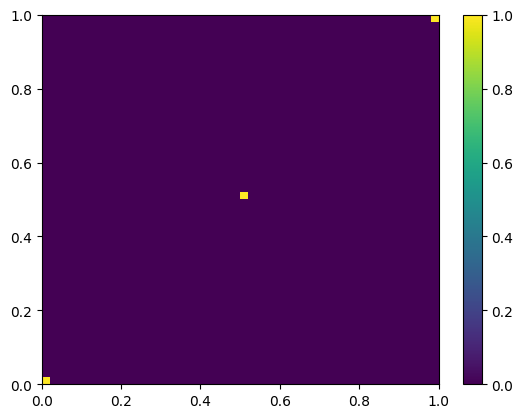

In [ ]:
plt.figure()
h = plt.hist2d(x, y, bins=[xbins, ybins])
plt.colorbar(h[-1])
# plt.clim(-1, 1)

plt.show()

In [5]:
counts, xEdges, yEdges, _ = h
integral2d(counts, xEdges, yEdges, x_lo=None, x_up=None, y_lo=None, y_up=None)

3.0

In [25]:
eps = 1e-12
integral2d(counts, xEdges, yEdges, x_lo=0.00, x_up=0.5-eps, y_lo=None, y_up=None)

1.0

In [17]:
np.linspace(1.0, 55, 5)[1:-1]

array([14.5, 28. , 41.5])

In [262]:
means = np.array([0.3, 0.4])
cov = np.array([[0.5, 0],[0, 0.5]]) * 1e-1
bkg = np.random.multivariate_normal(means, cov, 10000)

means = np.array([0.5, 0.8])
cov = np.array([[0.5, 0.3],[0.3, 0.5]]) * 1e-12
sig = np.random.multivariate_normal(means, cov, 10000)

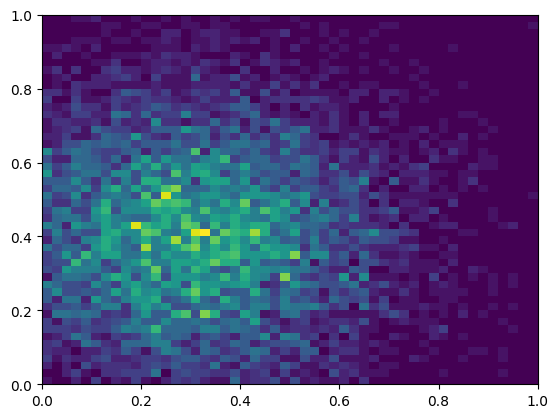

In [263]:
plt.figure()
bkg_hist = plt.hist2d(bkg[:,0], bkg[:,1], bins=[xbins, ybins])
plt.show()

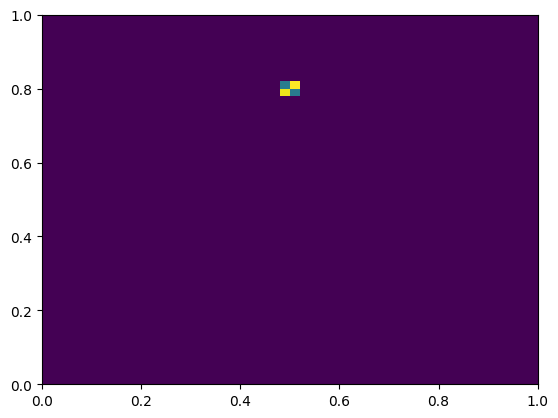

In [264]:
plt.figure()
sig_hist = plt.hist2d(sig[:,0], sig[:,1], bins=[xbins, ybins])
plt.show()

In [265]:
sig_counts, xEdges, yEdges, _ = sig_hist
bkg_counts, _     , _     , _ = bkg_hist

In [266]:
asimov_Z = np.vectorize(
    lambda ss, bb, dd: ROOT.RooStats.AsimovSignificance(float(ss), float(bb), float(dd)),
    otypes=[float])

In [269]:
def scan_Z(sig_counts, bkg_counts, xEdges, yEdges,
                  x_thr, y_thr, *, rel_unc=0.20, minB=0.50):
    # counter numerical errors
    eps = 1e-3
    
    
    nx, ny = sig_counts.shape
    x_thr = np.asarray(x_thr, float)
    y_thr = np.asarray(y_thr, float)

    Z    = np.full((len(x_thr), len(y_thr)), 0, dtype=float)
    Ssum = np.full_like(Z, 0)
    Bsum = np.full_like(Z, 0)

    for i, tx in enumerate(x_thr):
        for j, ty in enumerate(y_thr):
            # if tx != 0.9 or ty != 0.025: continue
            sigTR = integral2d(sig_counts, xEdges, yEdges, tx, None, ty, None)
            bkgTR = integral2d(bkg_counts, xEdges, yEdges, tx, None, ty, None)
            S = float(sigTR)
            B = float(bkgTR)
            B_eff = max(B, minB)
            S_eff = max(S, eps)
            Z[i, j] = asimov_Z(S_eff, B_eff, B_eff * rel_unc)
            # print(S_eff, B_eff, B_eff * rel_unc, asimov_Z(S_eff, B_eff, B_eff * rel_unc))
            Ssum[i, j] = S_eff
            Bsum[i, j] = B_eff

    return Z, Ssum, Bsum

/home/agueven/.conda/envs/coffea_torch2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


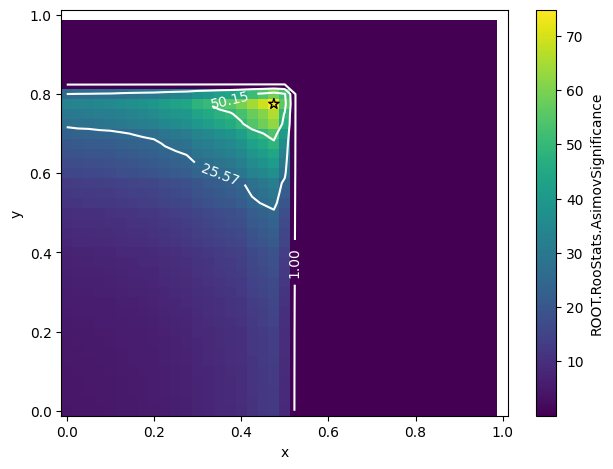

In [271]:
x_thr = np.linspace(0.0, 1.00, 41)
y_thr = np.linspace(0.0, 1.00, 41)

Z, _, _ = scan_Z(sig_counts, bkg_counts, xEdges, yEdges, x_thr, y_thr,
                        rel_unc=0.20, minB=0.50)

Z_imax = np.nanargmax(Z)
Z_max = np.nanmax(Z)

plt.figure()
# When passing 1D edges to pcolormesh, transpose Z
pcm = plt.pcolormesh(x_thr, y_thr, Z.T, shading="auto")
cont = plt.contour(x_thr, y_thr, Z.T, levels=np.linspace(1, np.nanmax(Z), 4), colors='white')

ix, iy = np.unravel_index(Z_imax, Z.shape)
plt.scatter([x_thr[ix]], [y_thr[iy]], s=60, marker="*", edgecolor="k", facecolor="none", label="best")

plt.xlabel("x")
plt.ylabel("y")
cbar = plt.colorbar(pcm)
plt.clabel(cont)
cbar.set_label("ROOT.RooStats.AsimovSignificance")
plt.tight_layout()
plt.show()

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(50, 50)),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <m

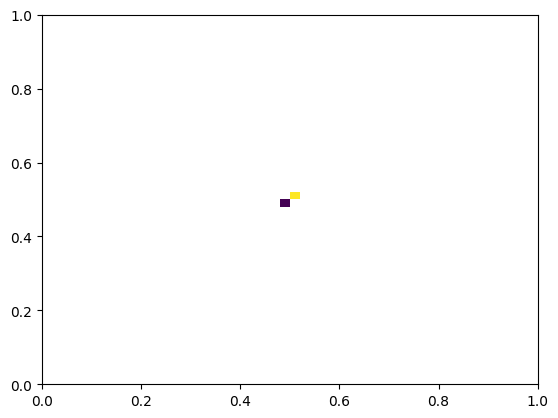

In [ ]:
from matplotlib.colors import LogNorm
plt.hist2d(np.array([0.49, 0.5, 0.51]),
           np.array([0.49, 0.5, 0.51]),
           bins=[xbins, ybins],
           range=[xbins[0]]
           density=True,
           cmin=1e-3,                         # hide very-sparse bins
           norm=LogNorm()                     # temporary; will override vmin/vmax below
    )